In [1]:
ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is DA12-76BE

 Directory of C:\Workspace\Qriocity\Assignments\Wildfire

26-07-2025  11:42    <DIR>          .
26-07-2025  11:39    <DIR>          ..
26-07-2025  11:42    <DIR>          .ipynb_checkpoints
26-07-2025  11:39    <DIR>          modis_2024_all_countries
26-07-2025  11:39        84,548,676 modis_2024_all_countries.zip
26-07-2025  11:42               337 Untitled.ipynb
               2 File(s)     84,549,013 bytes
               4 Dir(s)   4,410,974,208 bytes free


In [1]:
import pandas as pd

df = pd.read_csv("modis_2024_all_countries/modis_2024_United_Kingdom.csv")

In [2]:
df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,51.5638,-3.7686,304.9,1.0,1.0,2024-01-09,1043,Terra,MODIS,0,61.03,273.8,11.2,D,2
1,51.5757,-3.7687,301.1,2.0,1.4,2024-01-22,336,Aqua,MODIS,38,61.03,279.1,23.7,N,2
2,58.1543,-5.1865,344.9,1.6,1.2,2024-01-28,1402,Aqua,MODIS,81,61.03,280.5,105.4,D,0
3,58.1680,-5.1696,352.8,1.6,1.2,2024-01-28,1402,Aqua,MODIS,71,61.03,280.0,132.5,D,0
4,58.1548,-5.1937,334.7,1.6,1.2,2024-01-28,1402,Aqua,MODIS,80,61.03,280.8,69.7,D,0


In [3]:
df = df[df['confidence'] >= 40]

## Data Preprocessing

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler = MinMaxScaler()
features_to_scale = ['brightness', 'scan', 'track', 'bright_t31', 'frp']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Feature Engineering

In [6]:
df['daynight'] = df['daynight'].map({'D': 1, 'N': 0})

In [7]:
#Fire Risk Index
df['fire_risk_index'] = df['brightness'] * df['frp'] * df['daynight']

In [8]:
df['frp_lag1'] = df['frp'].shift(1)
df['brightness_lag1'] = df['brightness'].shift(1)
df = df.dropna()

In [26]:
df['brightness/frp'] = df['brightness'] / (df['frp'] + 1e-3)
df['temp_diff'] = df['brightness'] - df['bright_t31']

In [36]:
df = df[df['type'].isin([0, 2])]


In [14]:
df = df[df['type'].isin([0, 2])].copy()  # ← use .copy() to avoid side effects


In [15]:
print(df['type'].value_counts())


type
0    196
2     69
Name: count, dtype: int64


#  Model Building

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [17]:
X = df[['brightness', 'frp', 'bright_t31', 'fire_risk_index', 'daynight']]
y = df['type']  

In [20]:
print(y.value_counts())


type
0    196
2     69
Name: count, dtype: int64


In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

## Random forest

In [28]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced')

In [57]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63        38
           2       0.66      0.76      0.70        41

    accuracy                           0.67        79
   macro avg       0.67      0.67      0.67        79
weighted avg       0.67      0.67      0.67        79



## xgboost 

In [32]:
from xgboost import XGBClassifier
import numpy as np

for missing_class in [0, 1, 2]:
    if missing_class not in y_train.values:
        X_train = pd.concat([X_train, X_train.iloc[[0]]])
        y_train = pd.concat([y_train, pd.Series([missing_class])])


In [33]:
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)


C:\Users\Shubam\anaconda31\envs\ns\lib\site-packages\xgboost\training.py:183: UserWarning: [11:58:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [56]:
from sklearn.metrics import classification_report

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.66      0.69        38
           2       0.71      0.78      0.74        41

    accuracy                           0.72        79
   macro avg       0.72      0.72      0.72        79
weighted avg       0.72      0.72      0.72        79



## GCN Graph based

In [36]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix
import numpy as np

# ✅ Preprocess features
df = df[df['type'].isin([0, 2])]
features = df[['brightness', 'frp', 'bright_t31', 'daynight']].values
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [38]:
positions = df[['latitude', 'longitude']].values
dists = distance_matrix(positions, positions)

In [39]:
edge_index = []
threshold = 0.5  # degree distance
for i in range(len(dists)):
    for j in range(len(dists)):
        if i != j and dists[i, j] < threshold:
            edge_index.append([i, j])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [44]:
df = df[df['type'].isin([0, 2])].copy()
df['type'] = df['type'].map({0: 0, 2: 1})  # 🔁 remap class 2 → 1


In [45]:
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(df['type'].values, dtype=torch.long)


In [46]:
data = Data(x=x, edge_index=edge_index, y=y)

In [47]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=x.shape[1], hidden_channels=16, out_channels=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch} Loss: {loss.item():.4f}')


Epoch 0 Loss: 0.6940
Epoch 20 Loss: 0.3465
Epoch 40 Loss: 0.2900
Epoch 60 Loss: 0.2694
Epoch 80 Loss: 0.2537
Epoch 100 Loss: 0.2408
Epoch 120 Loss: 0.2307
Epoch 140 Loss: 0.2224
Epoch 160 Loss: 0.2144
Epoch 180 Loss: 0.2077


In [49]:
model.eval()
_, pred = model(data).max(dim=1)
correct = (pred == data.y).sum().item()
acc = correct / len(data.y)
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.9358


In [50]:
model.eval()
_, preds = model(data).max(dim=1)  # predicted class (0 or 1)

preds = preds.cpu().numpy()
labels = data.y.cpu().numpy()
coords = df[['latitude', 'longitude']].values


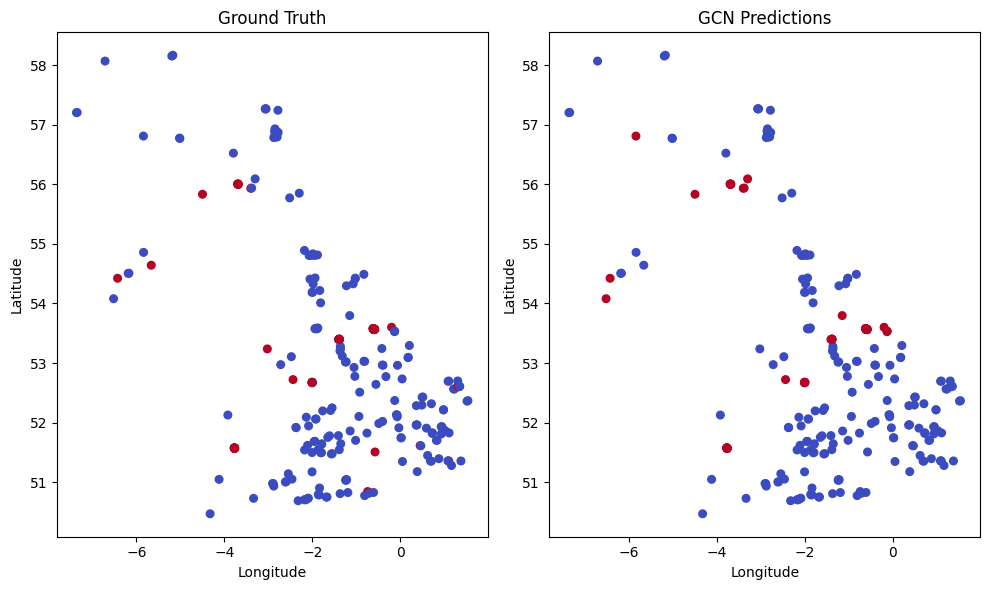

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# ✅ Ground Truth
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.scatter(coords[:, 1], coords[:, 0], c=labels, cmap='coolwarm', s=30)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# ✅ GCN Predictions
plt.subplot(1, 2, 2)
plt.title("GCN Predictions")
plt.scatter(coords[:, 1], coords[:, 0], c=preds, cmap='coolwarm', s=30)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


In [52]:
import folium
from folium.plugins import MarkerCluster

# Reuse coords, preds from earlier
coords = df[['latitude', 'longitude']].values
model.eval()
_, preds = model(data).max(dim=1)
preds = preds.cpu().numpy()

# Center map
center_lat, center_lon = coords[:, 0].mean(), coords[:, 1].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

marker_cluster = MarkerCluster().add_to(m)

# 🔴 = fire (class 1), 🔵 = not fire (class 0)
for i in range(len(coords)):
    color = 'red' if preds[i] == 1 else 'blue'
    folium.CircleMarker(
        location=[coords[i][0], coords[i][1]],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Prediction: {'🔥 Fire Risk' if preds[i] == 1 else '✅ No Risk'}"
    ).add_to(marker_cluster)

# Save and view
m.save("fire_risk_map.html")


In [53]:
from IPython.display import IFrame

m.save("fire_risk_map.html")
IFrame("fire_risk_map.html", width=900, height=600)


In [54]:
import torch

torch.save(model.state_dict(), "gcn_fire_model.pt")


In [55]:
import joblib

joblib.dump(scaler, "scaler_fire.pkl")


['scaler_fire.pkl']